In [1]:
#https://docs.openvino.ai/latest/notebooks/002-openvino-api-with-output.html
import cv2
import matplotlib.pyplot as plt
import numpy as np
import sys
import os, sys

In [2]:
from openvino.runtime import Core

ie = Core()
model_xml = "./logs/lego_test/model_fine_300000/xml/saved_model.xml"
model = ie.read_model(model=model_xml)
compile_model = ie.compile_model(model=model, device_name="CPU")

In [3]:
compile_model.outputs[0]

<ConstOutput: names[Func/StatefulPartitionedCall/output/_25:0, StatefulPartitionedCall/model_1/tf.concat_5/concat:0, Identity:0, StatefulPartitionedCall/Identity:0] shape{?,4} type: f32>

In [4]:
compile_model.inputs[0]

<ConstOutput: names[Func/StatefulPartitionedCall/input/_0:0, input_2:0] shape{?,90} type: f32>

(106, 100, 100, 3) (106, 4, 4) 138.88887889922103


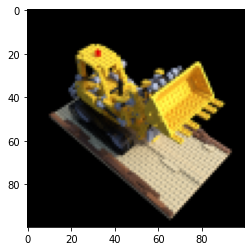

In [5]:
data = np.load('./data/tiny_nerf_data.npz')
images = data['images']
poses = data['poses']
focal = data['focal']
H, W = images.shape[1:3]
print(images.shape, poses.shape, focal)

testimg, testpose = images[101], poses[101]
images = images[:100,...,:3]
poses = poses[:100]

plt.imshow(testimg)
plt.show()

In [6]:
def posenc(x):
    rets = []
    for i in range(P_embed):
        for fn in [np.sin, np.cos]:
            rets.append(fn(2.**i * x))
    return np.concatenate(rets, -1)

P_embed = 10
embed_fn = posenc

In [7]:
def viewenc(x):
    rets = []
    for i in range(V_embed):
        for fn in [np.sin, np.cos]:
            rets.append(fn(2.**i * x))
    return np.concatenate(rets, -1)

V_embed = 5
embeddirs_fn = viewenc

In [8]:
def get_rays(H, W, focal, c2w):
    x = np.linspace(0, H-1, H)
    y = np.linspace(0, W-1, W)
    i, j = np.meshgrid(x, y, indexing='ij')
    dirs = np.stack([(i-W*.5)/focal, -(j-H*.5)/focal, -np.ones_like(i)], -1)
    rays_d = np.sum(dirs[..., np.newaxis, :] * c2w[:3,:3], -1)
    rays_o = np.broadcast_to(c2w[:3,-1], np.shape(rays_d))
    return rays_o, rays_d

In [11]:
import tensorflow as tf

def render_rays(network_fn, rays_o, rays_d, near, far, N_samples, rand=False):

    # Compute 3D query points
    z_vals = np.linspace(near, far, N_samples) 
    if rand:
        z_vals += np.random.uniform(list(rays_o.shape[:-1]) + [N_samples]) * (far-near)/N_samples
    pts = rays_o[...,None,:] + rays_d[...,None,:] * z_vals[...,:,None]
    
    pts_flat = np.reshape(pts, [-1, pts.shape[-1]])
    embedded = embed_fn(pts_flat)
    
    #prepare input_data
    #print(pts.shape)
    viewdirs = rays_d 
    input_dirs = np.broadcast_to(viewdirs[:,:, None], pts.shape)
    #print(input_dirs.shape)
    input_dirs_flat = np.reshape(input_dirs, [-1, input_dirs.shape[-1]])
    embedded_dirs = embeddirs_fn(input_dirs_flat)
    input_data = np.concatenate([embedded, embedded_dirs], -1)
    print(input_data.shape)
    
    # Run network
    input_layer = network_fn.inputs[0]
    output_layer = network_fn.outputs[0]
    request = network_fn.create_infer_request()
    rets = []
    chunk=1024*64
    for i in range(0, input_data.shape[0], chunk):
        request.infer(inputs={input_layer.any_name: input_data[i:i+chunk]})
        data = request.get_output_tensor(output_layer.index).data
        rets.append(data)
        print(data.shape)
    raw = np.concatenate(rets, 0)
    raw = np.reshape(raw, list(pts.shape[:-1]) + [4]) # H:W:Samples:4

    def ReLU(x):
        return x * (x > 0)
    def Sigmoid(x):
        return  1/(1 + np.exp(-x)) 

    # Compute opacities and colors
    sigma_a =  ReLU(raw[...,3])
    rgb =Sigmoid(-raw[...,:3])
    
    # Do volume rendering
    dists = np.concatenate([z_vals[..., 1:] - z_vals[..., :-1], np.broadcast_to([1e10], z_vals[...,:1].shape)], -1) 
    alpha = 1.-np.exp(-sigma_a * dists)  
    weights = alpha * np.cumprod(1.-alpha + 1e-10, -1)
    
    rgb_map = np.sum(weights[...,None] * rgb, -2) 
    return rgb_map

(100, 100, 64, 3)
(100, 100, 64, 3)
(640000, 90)
(65536, 4)
(65536, 4)
(65536, 4)
(65536, 4)
(65536, 4)
(65536, 4)
(65536, 4)
(65536, 4)
(65536, 4)
(50176, 4)
5.826032876968384 secs per iter


<ipython-input-11-1f76ed3e740f>:42: RuntimeWarning: overflow encountered in exp
  return  1/(1 + np.exp(-x))


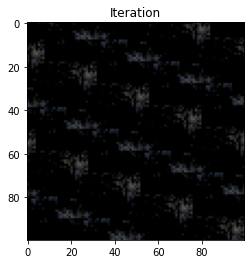

Done


In [12]:
N_samples = 64


import time
t = time.time()
pose = poses[0]
rays_o, rays_d = get_rays(H, W, focal, pose)
rgb = render_rays(compile_model, rays_o, rays_d, near=2., far=6., N_samples=N_samples, rand=False)
    
print(time.time() - t, 'secs per iter')
plt.imshow(rgb)
plt.title(f'Iteration')
plt.show()
print('Done')